In [1]:
# based on https://scitools.org.uk/cartopy/docs/latest/gallery/hurricane_katrina.html#sphx-glr-gallery-hurricane-katrina-py

# inspiration  https://www.nytimes.com/interactive/2017/08/24/us/hurricane-harvey-texas.html

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import pandas as pd
import folium

%matplotlib inline

In [2]:
def prep_data(filename):
    data = pd.read_csv(filename, sep=" ", usecols=[0,1,2,3])
    lons = data['Longitude']
    lats = data['Latitude']
    return(list(-1*lons), list(lats))

    

In [26]:
(hurricane_csv.loc[hurricane_csv['name'] == "Amy"]["category"]).max()

0

In [57]:
def sample_data():
    """
    Return a list of latitudes and a list of longitudes (lons, lats)
    for Hurricane Katrina (2005).

    The data was originally sourced from the HURDAT2 dataset from AOML/NOAA:
    http://www.aoml.noaa.gov/hrd/hurdat/newhurdat-all.html on 14th Dec 2012.

    """
    lons = [-75.1, -75.7, -76.2, -76.5, -76.9, -77.7, -78.4, -79.0,
            -79.6, -80.1, -80.3, -81.3, -82.0, -82.6, -83.3, -84.0,
            -84.7, -85.3, -85.9, -86.7, -87.7, -88.6, -89.2, -89.6,
            -89.6, -89.6, -89.6, -89.6, -89.1, -88.6, -88.0, -87.0,
            -85.3, -82.9]

    lats = [23.1, 23.4, 23.8, 24.5, 25.4, 26.0, 26.1, 26.2, 26.2, 26.0,
            25.9, 25.4, 25.1, 24.9, 24.6, 24.4, 24.4, 24.5, 24.8, 25.2,
            25.7, 26.3, 27.2, 28.2, 29.3, 29.5, 30.2, 31.1, 32.6, 34.1,
            35.6, 37.0, 38.6, 40.1]
    return lons, lats

hurricane_csv = pd.read_csv('storms.csv', sep=",")

def hurricane_data(name):
    #costs = pd.read_csv('hurricane_costs.csv', sep=",")
    lons = hurricane_csv.loc[hurricane_csv['name'] == name]["long"]
    lats = hurricane_csv.loc[hurricane_csv['name'] == name]["lat"]
    category = (hurricane_csv.loc[hurricane_csv['name'] == name]["category"]).max()
    return(lons, lats, category, name)

def visualize_track(storms):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)


    # to get the effect of having just the states without a map "background"
    # turn off the outline and background patches
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)

    ax.set_title('US States which intersect the track of Major Hurricanes\n (>3 billion USD)')
    #ax.set_title('US States which intersect the track of recent hurricanes')
    
    # turn the lons and lats into shapely LineStrings
    cane_tracks = []
    for name in storms:
        lons, lats, category, name = hurricane_data(name)
        cane_tracks.append(sgeom.LineString(zip(lons, lats)))
    
    # buffer the linestring by two degrees (note: this is a non-physical
    # distance)
    
    #cane_buffers = []
    #for track in cane_tracks:
    #    cane_buffers.append(track.buffer(2))
        
    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        for track in cane_tracks:
            track_buffer = track.buffer(2)
            if geometry.intersects(track):
                facecolor = 'red'
                break
            elif geometry.intersects(track_buffer):
                facecolor = '#FF7E00'
        return {'facecolor': facecolor, 'edgecolor': 'black'}
    
    def color_track(geometry):
        print(geometry)
        return {'facecolor': facecolor, 'edgecolor': 'black'}
        

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state)

    #ax.add_geometries(cane_buffers, ccrs.PlateCarree(),
    #                  facecolor='#C8A2C8', alpha=0.5)
    ax.add_geometries(cane_tracks, ccrs.PlateCarree(),
                      facecolor='none', edgecolor='blue')    

    # make two proxy artists to add to a legend
    direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
    within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")
    labels = ['State directly intersects\nwith track',
              'State is within \n2 degrees of track']
    ax.legend([direct_hit, within_2_deg], labels,
              loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)

    plt.show()
    

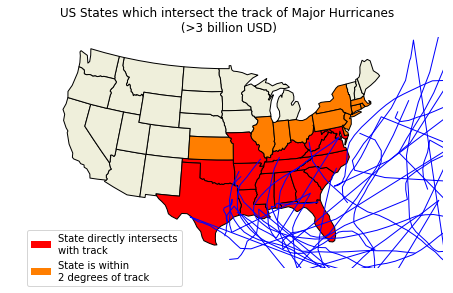

In [58]:
major_storms = ["Katrina","Harvey","Maria","Sandy","Irma","Ike","Wilma","Andrew","Ivan","Rita","Charley","Florence",
          "Matthew","Irene","Frances","Hugo","Georges","Allison","Gustav"]


all_storms = hurricane_csv.name.unique()

visualize_track(major_storms)

In [76]:
m = folium.Map([36, -75], zoom_start=3, tiles='OpenStreetMap',)

color_cat = {-1: "white", 0: "white", 1: "blue", 2: 'green', 3: 'purple', 4: 'red', 5: 'black'}

cane_tracks = []
for name in all_storms:
    lons, lats, category, name = hurricane_data(name)
    #lons, lats = sample_data()
    points = list(zip(lats, lons))
    #print(points)
    try:
        folium.PolyLine(points, color=color_cat[category], popup=name, weight=1, opacity=.5).add_to(m)
    except ValueError:
        pass
    except KeyError:
        pass
    
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 100px; height: 180px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; <strong>Legend</strong> <br><br>
                              &nbsp; Cat 0 &nbsp; <strong><i style="color:white">---</i></strong><br>
                              &nbsp; Cat 1 &nbsp; <strong><i style="color:blue">---</i></strong><br>
                              &nbsp; Cat 2 &nbsp; <strong><i style="color:green">---</i></strong><br>
                              &nbsp; Cat 3 &nbsp; <strong><i style="color:purple">---</i></strong><br>
                              &nbsp; Cat 4 &nbsp; <strong><i style="color:red">---</i></strong><br>
                              &nbsp; Cat 5 &nbsp; <strong><i style="color:black">---</i></strong>
                </div>
                ''' 

m.get_root().html.add_child(folium.Element(legend_html))
#folium.LayerControl().add_to(m)

    
m